In [13]:
import sys
sys.path.append("..") # Ensure the parent directory is in the path

import core.assingment as Models
from core.DataLoader import DataPreprocessor, DataConfig
import core
import numpy as np
from importlib import reload
import keras
import matplotlib.pyplot as plt
MAX_JETS = 6
PLOTS_DIR = f"plots/"
import os
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

config = DataConfig(jet_features=["ordered_jet_pt","ordered_jet_eta", "ordered_jet_phi","ordered_jet_e","ordered_jet_b_tag"], 
                                lepton_features=["lep_pt", "lep_eta", "lep_phi", "lep_e"],
                                jet_truth_label="ordered_event_jet_truth_idx", 
                                lepton_truth_label="event_lepton_truth_idx", 
                                global_features = ["met_met_NOSYS","met_phi_NOSYS"], 
                                max_leptons=2, 
                                max_jets = MAX_JETS, 
                                non_training_features =["truth_ttbar_mass", "truth_ttbar_pt", "N_jets"], 
                                event_weight="weight_mc_NOSYS")

DataProcessor = DataPreprocessor(config)
DataProcessor.load_data("/data/dust/group/atlas/ttreco/full_training.root", "reco", max_events=1000000)
#DataProcessor.normalise_data()
X_train,y_train, X_val, y_val = DataProcessor.split_data(test_size=0.1, random_state=42)

In [14]:
reload(Models)
reload(core)
TransformerMatcher = Models.FeatureConcatTransformer(config, name="Transformer")

TransformerMatcher.build_model(
    num_heads=8,
    hidden_dim=64,
    num_layers=6,
    dropout_rate=0.1
)
TransformerMatcher.adapt_normalization_layers(X_train)

TransformerMatcher.compile_model(
    loss = core.utils.AssignmentLoss(lambda_excl=0), optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4), metrics=[core.utils.AssignmentAccuracy()]
)
TransformerMatcher.model.summary()
TransformerMatcher.load_model("Transformer_Assignment.keras")

Model: "FeatureConcatTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ global_inputs       │ (None, 1, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_inputs          │ (None, 2, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_input_norma… │ (None, 1, 2)      │          5 │ global_inputs[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_input_normaliz… │ (None, 2, 4)      │          9 │ lep_inputs[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_inputs          │ (None, 6, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 2)         │          0 │ global_input_nor… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 8)         │          0 │ lep_input_normal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_input_normaliz… │ (None, 6, 5)      │         11 │ jet_inputs[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 6, 2)      │          0 │ flatten_2[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 6, 8)      │          0 │ flatten_3[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 6, 15)     │          0 │ jet_input_normal… │
│ (Concatenate)       │                   │            │ repeat_vector_2[… │
│                     │                   │            │ repeat_vector_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_embedding (MLP) │ (None, 6, 64)     │      3,919 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_mask            │ (None, 6, 1)      │          0 │ jet_inputs[0][0]  │
│ (GenerateMask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_blo… │ (None, 6, 64)     │     33,472 │ jet_embedding[0]… │
│ (SelfAttentionBloc… │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_blo… │ (None, 6, 64)     │     33,472 │ self_attention_b… │
│ (SelfAttentionBloc… │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_blo… │ (None, 6, 64)     │     33,472 │ self_attention_b… │
│ (SelfAttentionBloc… │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_blo… │ (None, 6, 64)     │     33,472 │ self_attention_b… │
│ (SelfAttentionBloc… │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 206,216 (805.54 KB)

 Trainable params: 206,191 (805.43 KB)

 Non-trainable params: 25 (112.00 B)

Model loaded from Transformer_Assignment.keras


In [ ]:
TransformerMatcher.train_model(epochs=50,
                                X_train=X_train,
                                y_train=y_train,
                                sample_weights=core.utils.compute_sample_weights(X_train, y_train),
                                batch_size=128,
                                callbacks = keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, mode ="min"))

In [ ]:
TransformerMatcher.save_model("Transformer_Assignment.keras")

In [ ]:
pred_val = TransformerMatcher.predict_indices(X_val)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(y_val[:,:,1].argmax(axis=-1),pred_val[:,:,1].argmax(axis=-1), normalize="true", ax=ax)
plt.savefig(PLOTS_DIR+"/confusion_matrix_lepton.png")

In [ ]:
reload(core)
ml_eval = core.assingment.MLEvaluatorBase(TransformerMatcher, X_val, y_val)
importances = ml_eval.compute_permutation_importance(num_repeats=1)

In [ ]:
ml_eval.plot_feature_importance(importances)

In [ ]:
TransformerMatcher.export_to_onnx("Transformer_Assignment.onnx")

In [ ]:
import onnx
import onnxruntime as ort
onnx_model = onnx.load("Transformer_Assignment.onnx")
onnx.checker.check_model(onnx_model)
ort_session = ort.InferenceSession("Transformer_Assignment.onnx")
flatted_inputs = np.concatenate([X_val['jet'].reshape(X_val['jet'].shape[0], -1), X_val['lepton'].reshape(X_val['lepton'].shape[0], -1), X_val['global'].reshape(X_val["global"].shape[0],-1)], axis=-1).astype(np.float32)

In [ ]:
outputs = ort_session.run(None, {"flat_input": flatted_inputs})[0]

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val[:,:,0].argmax(axis=-1),outputs[:,:,0].argmax(axis=-1), normalize="true")


In [ ]:
import onnx

model = onnx.load("Transformer_Assignment.onnx")
print([inp.name for inp in model.graph.input])
print([out.name for out in model.graph.output])

In [18]:
import core.assingment.BaselineMethods as BaselineMethods
import core.assingment.Evaluation as Evaluation
reload(Evaluation)
reload(BaselineMethods)
delta_r_assigner = BaselineMethods.DeltaRAssigner(config, name=r"$\Delta R$-Assignment")
invariant_mass_assigner = BaselineMethods.LeptonJetMassAssigner(config, name = r"$m(\ell, j)$-Assignment")

evaluator = Evaluation.JetAssignmentEvaluator([delta_r_assigner,invariant_mass_assigner,TransformerMatcher], X_val, y_val)


Computing binned accuracy for truth_ttbar_mass...


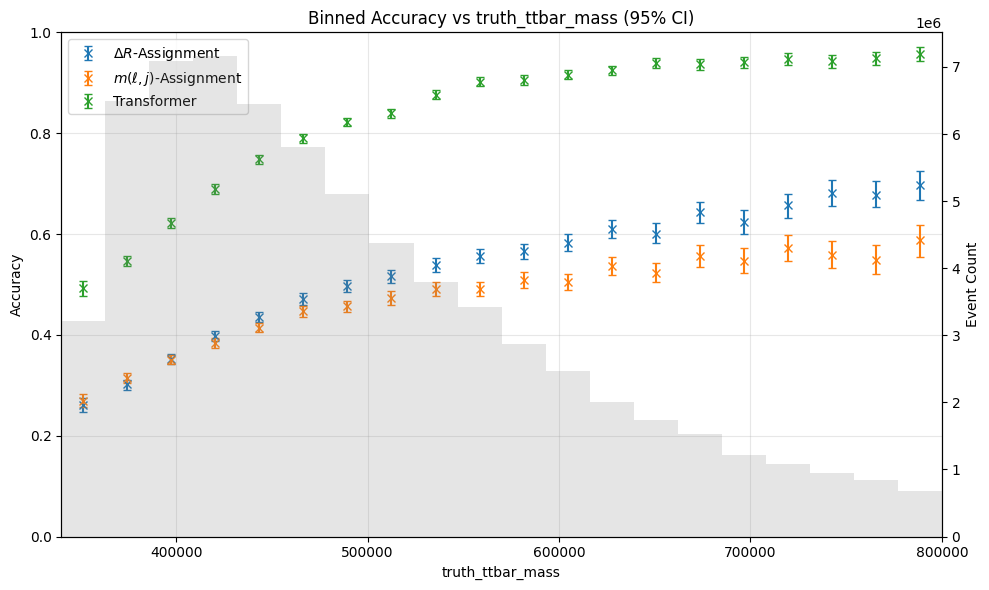

In [21]:
evaluator.plot_binned_accuracy(feature_data_type='non_training', feature_name='truth_ttbar_mass', xlims = (340e3,800e3))

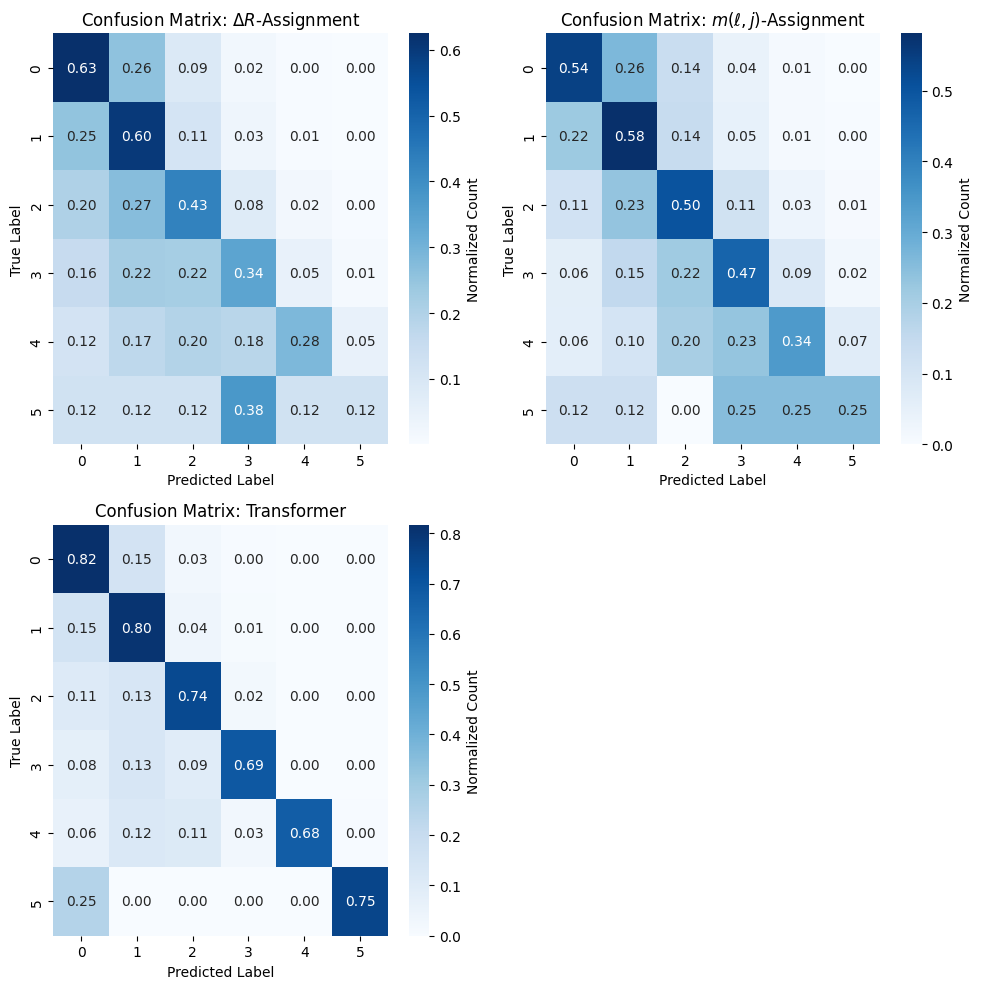

(<Figure size 1000x1000 with 6 Axes>,
 array([<Axes: title={'center': 'Confusion Matrix: $\\Delta R$-Assignment'}, xlabel='Predicted Label', ylabel='True Label'>,
        <Axes: title={'center': 'Confusion Matrix: $m(\\ell, j)$-Assignment'}, xlabel='Predicted Label', ylabel='True Label'>,
        <Axes: title={'center': 'Confusion Matrix: Transformer'}, xlabel='Predicted Label', ylabel='True Label'>],
       dtype=object))

In [22]:
evaluator.plot_confusion_matrices()